# 0. Install and Import Dependencies

In [3]:
!pip list

In [4]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [5]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [6]:
tf.config.list_physical_devices('GPU')

[]

In [7]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [7]:
pip install gdown

     ------------------------------------ 143.0/143.0 kB 293.0 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import gdown

In [9]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=c48d8e1d-8c62-437d-8cae-f28a2cdbbc1c
To: c:\Users\User\Downloads\data.zip
100%|██████████| 423M/423M [19:26<00:00, 363kB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [128]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [129]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [130]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [131]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [132]:
char_to_num(['r','o','h','i','t'])

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([18, 15,  8,  9, 20], dtype=int64)>

In [133]:
num_to_char([18,  15,  8, 9, 20])

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'r', b'o', b'h', b'i', b't'], dtype=object)>

In [134]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [135]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [136]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [137]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [138]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

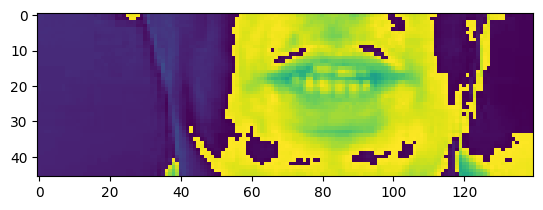

In [139]:
plt.imshow(frames[40])

In [140]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [141]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [142]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [143]:
from matplotlib import pyplot as plt

In [144]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [145]:
print(train)

<TakeDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>


In [146]:
len(test)

50

In [147]:
frames, alignments = data.as_numpy_iterator().next()

In [148]:
len(frames)

2

In [149]:
sample = data.as_numpy_iterator()

In [150]:
val = sample.next(); val[0]

array([[[[[1.5242666 ],
          [1.5242666 ],
          [1.4870894 ],
          ...,
          [0.29741788],
          [0.29741788],
          [0.29741788]],

         [[1.5242666 ],
          [1.5242666 ],
          [1.4870894 ],
          ...,
          [0.29741788],
          [0.29741788],
          [0.29741788]],

         [[1.3383805 ],
          [1.3383805 ],
          [1.4127349 ],
          ...,
          [0.29741788],
          [0.29741788],
          [0.29741788]],

         ...,

         [[1.0037854 ],
          [1.0037854 ],
          [1.0037854 ],
          ...,
          [0.03717723],
          [0.        ],
          [0.        ]],

         [[1.0037854 ],
          [1.0037854 ],
          [1.0037854 ],
          ...,
          [0.03717723],
          [0.        ],
          [0.        ]],

         [[1.0037854 ],
          [1.0037854 ],
          [1.0037854 ],
          ...,
          [0.03717723],
          [0.        ],
          [9.480195  ]]],


        [[[1.4870

In [151]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 9.480195045471191]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.480195045471191]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.480195045471191]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.480195045471191]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.480195045471191]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.480195045471191]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.480195045471191]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

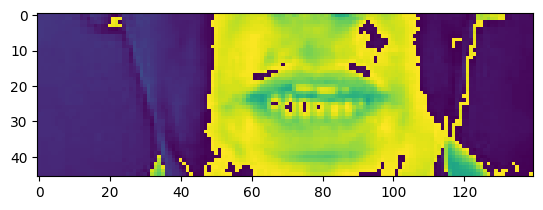

In [152]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [153]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin green in n two please'>

# 3. Design the Deep Neural Network

In [154]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [155]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [156]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

1. The model starts with a `Sequential` container.

2. It adds a `Conv3D` layer with 128 filters and a kernel size of 3, accepting input of shape (75, 46, 140, 1) with padding set to 'same'. An 'relu' activation function is applied, followed by a 3D max-pooling layer.

3. This pattern of adding a `Conv3D` layer, followed by an 'relu' activation and max-pooling, is repeated twice, first with 256 filters and then with 75 filters.

4. A `TimeDistributed` layer is added to apply the same dense layer to every temporal slice of the input.

5. Two `Bidirectional` LSTM layers with 128 units each are added, with 'Orthogonal' kernel initialization and a 'return_sequences' parameter set to True. A dropout layer is applied after each LSTM layer.

6. Finally, a `Dense` layer with the number of units equal to the vocabulary size plus one is added. It uses 'he_normal' kernel initialization and 'softmax' activation.

This architecture is suitable for sequential data, such as videos or time series, where the model learns spatial and temporal features simultaneously.

In [157]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 75, 46, 140, 128)  3584      
                                                                 
 activation_6 (Activation)   (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 75, 23, 70, 128)  0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_7 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                  

In [158]:
5*17*75

6375

In [159]:
yhat = model.predict(val[0])

1/1 [==============================] - 6s 6s/step


In [160]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'88888811111111111111111111111111111111111111111111111111111111111111111111a'>

In [161]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'88888811111111111111111111111111111111111111111111111111111111111111111111a'>

In [162]:
model.input_shape

(None, 75, 46, 140, 1)

In [163]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [164]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

The learning rate is constant for the first 30 epochs of training.
After the 30th epoch, it exponentially decays the learning rate by a factor of approximately 0.9048 for every subsequent epoch. This decay helps in fine-tuning the model's performance and convergence during the later stages of training.

In [165]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

This function calculates the Connectionist Temporal Classification (CTC) loss in TensorFlow . It takes the true and predicted values as inputs and uses TensorFlow functions to compute the loss, considering the variable lengths of the sequences. Finally, it returns the computed CTC loss

In [166]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

During training, it fetches data from the dataset, predicts using the model, decodes the predictions, and prints the original and predicted sequences for each batch at the end of every epoch. This helps in monitoring the model's performance during training.

In [172]:
model.compile(optimizer=Adam(learning_rate=0.1), loss=CTCLoss)

In [173]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [174]:
schedule_callback = LearningRateScheduler(scheduler)

In [175]:
example_callback = ProduceExample(test)

In [176]:
model.fit(train, validation_data=test, batch_size=4, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
 36/450 [=>............................] - ETA: 8:04:07 - loss: 517.0908

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node 'CTCLoss/CTCLoss' defined at (most recent call last):
    File "c:\Users\User\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "c:\Users\User\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\User\AppData\Roaming\Python\Python37\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\User\AppData\Roaming\Python\Python37\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\User\AppData\Local\Programs\Python\Python37\lib\asyncio\base_events.py", line 539, in run_forever
      self._run_once()
    File "c:\Users\User\AppData\Local\Programs\Python\Python37\lib\asyncio\base_events.py", line 1775, in _run_once
      handle._run()
    File "c:\Users\User\AppData\Local\Programs\Python\Python37\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\User\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 2976, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "C:\Users\User\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "C:\Users\User\AppData\Roaming\Python\Python37\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\User\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 3258, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "C:\Users\User\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\User\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\User\AppData\Local\Temp\ipykernel_13352\3536403359.py", line 1, in <module>
      model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])
    File "c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1053, in compute_loss
      y, y_pred, sample_weight, regularization_losses=self.losses
    File "c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\User\AppData\Local\Temp\ipykernel_13352\1034414693.py", line 9, in CTCLoss
      loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    File "c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\backend.py", line 7021, in ctc_batch_cost
      inputs=y_pred, labels=sparse_labels, sequence_length=input_length
Node: 'CTCLoss/CTCLoss'
Saw a non-null label (index >= num_classes - 1) following a null label, batch: 0 num_classes: 39 labels: 2,9,14,39,23,8,9,20,5,39,2,25,39,8,39,15,14,5,39,1,7,1,9,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 labels seen so far: 2,9,14
	 [[{{node CTCLoss/CTCLoss}}]] [Op:__inference_train_function_32144]

# 5. Make a Prediction 

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [ ]:
model.load_weights('models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

1/1 [==============================] - 1s 973ms/step


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white at x six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in x four now'>]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white at x six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in x four now'>]

# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 720ms/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]